In [105]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(tf.VERSION)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


Loading the data of the [Lakh MIDI Dataset v0.1](https://colinraffel.com/projects/lmd/).
We are interested in the `LMD-aligned`, which contains alignment with the Million Song Dataset (MSD), from which we can extract some metadata.

For each of the 31034 MSD tracks, we have:
- a MIDI file, from which we estracted **embeddings** with [midi2vec](https://github.com/midi-ld/midi2vec);
- a set of **metadata**, from which we extracted:
    - a tag related to the MusicBrainz artist (e.g. 'british', 'pop');
    - a tag related to the EchoNest artist (e.g. 'space rock',  'ballad');
    - the year of release of the track (coming from MusicBrainz).
    
Not all the tracks have all the selected tags, and some tags may include dirty text, like `carlos baute colgando en tus manos nada se compara a ti`

In [2]:
data = np.loadtxt('./dataset-lakh/vectors.txt')
tag_mbz = np.loadtxt('./dataset-lakh/tag_mbz.txt', dtype=np.str, delimiter=',')
tag_echo = np.loadtxt('./dataset-lakh/tag_echo.txt', dtype=np.str, delimiter=',')
year = np.loadtxt('./dataset-lakh/year.txt', dtype=np.str, delimiter=',')

The labels are represented with the 1-hot encoding

In [3]:
encoder = LabelBinarizer()
def onehot_labels(labels):
    return encoder.fit_transform(labels)
    
def onehot2str(onehot):
    return encoder.inverse_transform(np.array([onehot]))[0]

In [227]:
def clean_and_filter(what, min_count = 15, sort_by='value'):
    """
    Remove the '?' items and keep only the ones
    with more than min_count occurrences
    """
    u = Counter(what) # map label -> n. occurences
    
    enough_big = [(m not in ['?', '0'] and u[m] > min_count) for m in what]

    data_filtered = data[enough_big]
    what_filtered = what[enough_big]
    
    if sort_by =='value':
        x = Counter(what_filtered).most_common()
    elif sort_by == 'key':
        x = sorted(Counter(what_filtered).items())
    else:
        x = Counter(what_filtered).items()
        
    labels, values = zip(*x)
    indexes = np.arange(len(labels))
    width = 1

    plt.figure(figsize=(20,6))
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels, rotation='vertical')
    plt.show()

    return data_filtered, what_filtered

In [244]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, show_labels=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # one hot to index
    y_true = [np.where(r==1)[0][0] for r in y_true]
    # y_pred are already indexes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    classes = [c[0:10] if len(c) > 10 else c for c in classes]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    if show_labels: # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        plt.xticks(np.arange(cm.shape[1]),fontsize=6)
        plt.yticks(np.arange(cm.shape[0]),fontsize=6)
        
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
        
    plt.grid(True)
    plt.show()


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

### Experiment 1: MusicBrainz Tag 

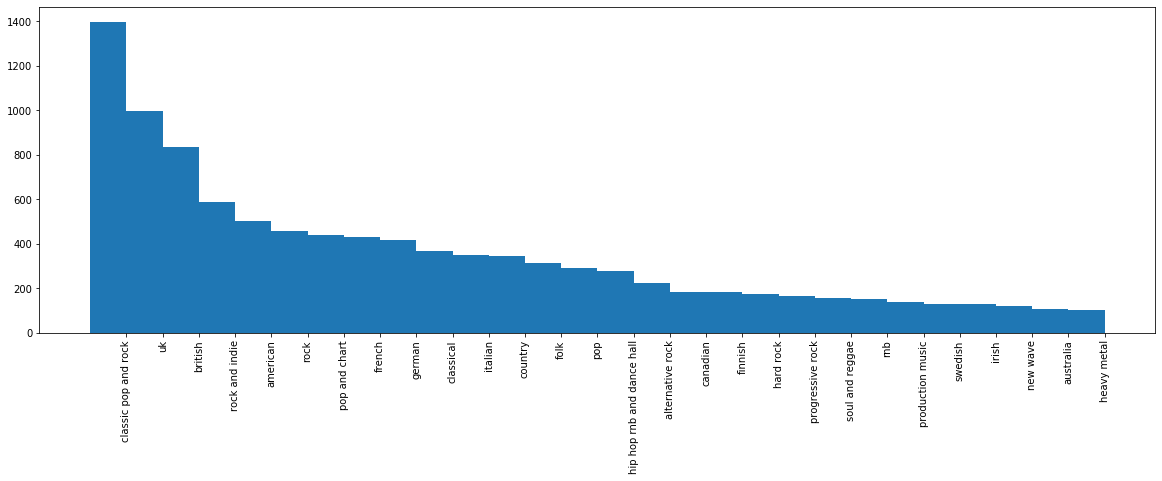

Distinct tag MBZ considered:


28

In [163]:
data_filtered, tag_mbz_filtered = clean_and_filter(tag_mbz, 100)

print('Distinct tag MBZ considered:')
len(np.unique(tag_mbz_filtered))

In [203]:
print('Total elements:')
len(data_filtered)

Total elements:


21895

In [142]:
labels_1hot = onehot_labels(tag_mbz_filtered)
    
onehot2str(labels_1hot[0])

'rock'

In [143]:
data_filtered.shape

(9954, 100)

In [144]:
labels_1hot.shape

(9954, 28)

In [145]:
num_input = data_filtered.shape[1]
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 28)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [146]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [147]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [148]:
random_state = 2111
scores = cross_val_score(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

Epoch 1/100
8958/8958 [==============================] - 1s 72us/sample - loss: 0.1494 - acc: 0.9627
Epoch 2/100
8958/8958 [==============================] - 0s 50us/sample - loss: 0.1387 - acc: 0.9644
Epoch 3/100
8958/8958 [==============================] - 0s 49us/sample - loss: 0.1357 - acc: 0.9646
Epoch 4/100
8958/8958 [==============================] - 0s 48us/sample - loss: 0.1329 - acc: 0.9648
Epoch 5/100
8958/8958 [==============================] - 0s 49us/sample - loss: 0.1298 - acc: 0.9651
Epoch 6/100
8958/8958 [==============================] - 0s 49us/sample - loss: 0.1263 - acc: 0.9653
Epoch 7/100
8958/8958 [==============================] - 0s 50us/sample - loss: 0.1230 - acc: 0.9659
Epoch 8/100
8958/8958 [==============================] - 0s 52us/sample - loss: 0.1199 - acc: 0.9662
Epoch 9/100
8958/8958 [==============================] - 0s 51us/sample - loss: 0.1174 - acc: 0.9667
Epoch 10/100
8958/8958 [==============================] - 0s 49us/sample - loss: 0.1145 - a

8958/8958 [==============================] - 0s 52us/sample - loss: 0.0681 - acc: 0.9776
Epoch 82/100
8958/8958 [==============================] - 0s 50us/sample - loss: 0.0689 - acc: 0.9776
Epoch 83/100
8958/8958 [==============================] - 0s 52us/sample - loss: 0.0672 - acc: 0.9778
Epoch 84/100
8958/8958 [==============================] - 0s 48us/sample - loss: 0.0663 - acc: 0.9782
Epoch 85/100
8958/8958 [==============================] - 0s 47us/sample - loss: 0.0669 - acc: 0.9781
Epoch 86/100
8958/8958 [==============================] - 0s 50us/sample - loss: 0.0677 - acc: 0.9776
Epoch 87/100
8958/8958 [==============================] - 0s 51us/sample - loss: 0.0700 - acc: 0.9772
Epoch 88/100
8958/8958 [==============================] - 0s 49us/sample - loss: 0.0683 - acc: 0.9776
Epoch 89/100
8958/8958 [==============================] - 0s 48us/sample - loss: 0.0661 - acc: 0.9781
Epoch 90/100
8958/8958 [==============================] - 0s 48us/sample - loss: 0.0647 - acc: 

8958/8958 [==============================] - 0s 56us/sample - loss: 0.0781 - acc: 0.9752
Epoch 61/100
8958/8958 [==============================] - 0s 55us/sample - loss: 0.0782 - acc: 0.9749
Epoch 62/100
8958/8958 [==============================] - 1s 63us/sample - loss: 0.0786 - acc: 0.9749
Epoch 63/100
8958/8958 [==============================] - 1s 77us/sample - loss: 0.0787 - acc: 0.9750
Epoch 64/100
8958/8958 [==============================] - 1s 81us/sample - loss: 0.0772 - acc: 0.9752
Epoch 65/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0765 - acc: 0.9755
Epoch 66/100
8958/8958 [==============================] - 1s 65us/sample - loss: 0.0775 - acc: 0.9754
Epoch 67/100
8958/8958 [==============================] - 1s 67us/sample - loss: 0.0771 - acc: 0.9752
Epoch 68/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0766 - acc: 0.9757
Epoch 69/100
8958/8958 [==============================] - 1s 57us/sample - loss: 0.0769 - acc: 

8958/8958 [==============================] - 0s 54us/sample - loss: 0.0830 - acc: 0.9736
Epoch 40/100
8958/8958 [==============================] - 0s 54us/sample - loss: 0.0826 - acc: 0.9740
Epoch 41/100
8958/8958 [==============================] - 0s 53us/sample - loss: 0.0823 - acc: 0.9737
Epoch 42/100
8958/8958 [==============================] - 0s 54us/sample - loss: 0.0806 - acc: 0.9744
Epoch 43/100
8958/8958 [==============================] - 0s 53us/sample - loss: 0.0817 - acc: 0.9744
Epoch 44/100
8958/8958 [==============================] - 1s 57us/sample - loss: 0.0811 - acc: 0.9744
Epoch 45/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0802 - acc: 0.9747
Epoch 46/100
8958/8958 [==============================] - 1s 66us/sample - loss: 0.0787 - acc: 0.9748
Epoch 47/100
8958/8958 [==============================] - 1s 67us/sample - loss: 0.0791 - acc: 0.9747
Epoch 48/100
8958/8958 [==============================] - 1s 66us/sample - loss: 0.0791 - acc: 

8958/8958 [==============================] - 1s 59us/sample - loss: 0.0996 - acc: 0.9705
Epoch 19/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0985 - acc: 0.9707
Epoch 20/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0969 - acc: 0.9709
Epoch 21/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0958 - acc: 0.9710
Epoch 22/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0946 - acc: 0.9713
Epoch 23/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0930 - acc: 0.9718
Epoch 24/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0926 - acc: 0.9718
Epoch 25/100
8958/8958 [==============================] - 1s 58us/sample - loss: 0.0916 - acc: 0.9722
Epoch 26/100
8958/8958 [==============================] - 1s 62us/sample - loss: 0.0909 - acc: 0.9719
Epoch 27/100
8958/8958 [==============================] - 1s 62us/sample - loss: 0.0898 - acc: 

8958/8958 [==============================] - 0s 54us/sample - loss: 0.0701 - acc: 0.9779
Epoch 99/100
8958/8958 [==============================] - 0s 56us/sample - loss: 0.0696 - acc: 0.9778
Epoch 100/100
996/996 [==============================] - 0s 171us/sample - loss: 0.4089 - acc: 0.9511
Epoch 1/100
8959/8959 [==============================] - 1s 79us/sample - loss: 0.1508 - acc: 0.9622
Epoch 2/100
8959/8959 [==============================] - 0s 56us/sample - loss: 0.1388 - acc: 0.9644
Epoch 3/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.1356 - acc: 0.9646
Epoch 4/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.1324 - acc: 0.9648
Epoch 5/100
8959/8959 [==============================] - 0s 55us/sample - loss: 0.1291 - acc: 0.9651
Epoch 6/100
8959/8959 [==============================] - 0s 55us/sample - loss: 0.1256 - acc: 0.9653
Epoch 7/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.1228 - acc: 0.9659


8959/8959 [==============================] - 1s 56us/sample - loss: 0.0685 - acc: 0.9776
Epoch 78/100
8959/8959 [==============================] - 1s 60us/sample - loss: 0.0689 - acc: 0.9773
Epoch 79/100
8959/8959 [==============================] - 1s 62us/sample - loss: 0.0697 - acc: 0.9772
Epoch 80/100
8959/8959 [==============================] - 0s 56us/sample - loss: 0.0698 - acc: 0.9771
Epoch 81/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.0675 - acc: 0.9781
Epoch 82/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.0671 - acc: 0.9778
Epoch 83/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.0683 - acc: 0.9775
Epoch 84/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.0677 - acc: 0.9779
Epoch 85/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.0696 - acc: 0.9775
Epoch 86/100
8959/8959 [==============================] - 1s 56us/sample - loss: 0.0669 - acc: 

8959/8959 [==============================] - 1s 57us/sample - loss: 0.0772 - acc: 0.9754
Epoch 57/100
8959/8959 [==============================] - 1s 59us/sample - loss: 0.0764 - acc: 0.9760
Epoch 58/100
8959/8959 [==============================] - 1s 58us/sample - loss: 0.0770 - acc: 0.9755
Epoch 59/100
8959/8959 [==============================] - 1s 58us/sample - loss: 0.0766 - acc: 0.9760
Epoch 60/100
8959/8959 [==============================] - 1s 58us/sample - loss: 0.0754 - acc: 0.9759
Epoch 61/100
8959/8959 [==============================] - 1s 58us/sample - loss: 0.0745 - acc: 0.9763
Epoch 62/100
8959/8959 [==============================] - 1s 58us/sample - loss: 0.0767 - acc: 0.9758
Epoch 63/100
8959/8959 [==============================] - 1s 59us/sample - loss: 0.0750 - acc: 0.9761
Epoch 64/100
8959/8959 [==============================] - 1s 61us/sample - loss: 0.0742 - acc: 0.9761
Epoch 65/100
8959/8959 [==============================] - 1s 58us/sample - loss: 0.0746 - acc: 

8959/8959 [==============================] - 1s 62us/sample - loss: 0.0818 - acc: 0.9740
Epoch 36/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0818 - acc: 0.9739
Epoch 37/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0808 - acc: 0.9741
Epoch 38/100
8959/8959 [==============================] - 1s 70us/sample - loss: 0.0806 - acc: 0.9743
Epoch 39/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0805 - acc: 0.9744
Epoch 40/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.0800 - acc: 0.9743
Epoch 41/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.0796 - acc: 0.9743
Epoch 42/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.0779 - acc: 0.9749
Epoch 43/100
8959/8959 [==============================] - 1s 58us/sample - loss: 0.0772 - acc: 0.9753
Epoch 44/100
8959/8959 [==============================] - 1s 59us/sample - loss: 0.0777 - acc: 

8959/8959 [==============================] - 1s 65us/sample - loss: 0.1080 - acc: 0.9685
Epoch 15/100
8959/8959 [==============================] - 1s 71us/sample - loss: 0.1055 - acc: 0.9688
Epoch 16/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.1040 - acc: 0.9692
Epoch 17/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.1024 - acc: 0.9694
Epoch 18/100
8959/8959 [==============================] - 1s 93us/sample - loss: 0.1008 - acc: 0.9696
Epoch 19/100
8959/8959 [==============================] - 1s 93us/sample - loss: 0.0996 - acc: 0.96970s - loss: 0.0955 - a
Epoch 20/100
8959/8959 [==============================] - 1s 87us/sample - loss: 0.0974 - acc: 0.9703
Epoch 21/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.0973 - acc: 0.9702
Epoch 22/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0961 - acc: 0.9706
Epoch 23/100
8959/8959 [==============================] - 1s 72us/sample -

8959/8959 [==============================] - 1s 64us/sample - loss: 0.0706 - acc: 0.9771
Epoch 95/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0713 - acc: 0.9772
Epoch 96/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0712 - acc: 0.9772
Epoch 97/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.0718 - acc: 0.9772
Epoch 98/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0702 - acc: 0.9773
Epoch 99/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0710 - acc: 0.9770
Epoch 100/100
995/995 [==============================] - 0s 205us/sample - loss: 0.3638 - acc: 0.9536
Epoch 1/100
8959/8959 [==============================] - 1s 108us/sample - loss: 0.1511 - acc: 0.9620
Epoch 2/100
8959/8959 [==============================] - 1s 71us/sample - loss: 0.1391 - acc: 0.9644
Epoch 3/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.1364 - acc: 0.

8959/8959 [==============================] - 1s 80us/sample - loss: 0.0741 - acc: 0.9761
Epoch 74/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0742 - acc: 0.9763
Epoch 75/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0742 - acc: 0.9762
Epoch 76/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0731 - acc: 0.9766
Epoch 77/100
8959/8959 [==============================] - 1s 79us/sample - loss: 0.0722 - acc: 0.9770
Epoch 78/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0712 - acc: 0.9771
Epoch 79/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0722 - acc: 0.9768
Epoch 80/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0721 - acc: 0.9769
Epoch 81/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0724 - acc: 0.9767
Epoch 82/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0730 - acc: 

8959/8959 [==============================] - 1s 67us/sample - loss: 0.0768 - acc: 0.9754
Epoch 53/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0766 - acc: 0.9755
Epoch 54/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.0757 - acc: 0.9758
Epoch 55/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.0764 - acc: 0.9755
Epoch 56/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.0751 - acc: 0.9759
Epoch 57/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0740 - acc: 0.9761
Epoch 58/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0741 - acc: 0.9763
Epoch 59/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.0755 - acc: 0.9759
Epoch 60/100
8959/8959 [==============================] - 1s 69us/sample - loss: 0.0732 - acc: 0.9764
Epoch 61/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.0736 - acc: 

array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95])

In [149]:
np.mean(scores)

0.9522593319416046

In [150]:
predicted = cross_val_predict(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

Epoch 1/100
8958/8958 [==============================] - 1s 100us/sample - loss: 0.1505 - acc: 0.9625
Epoch 2/100
8958/8958 [==============================] - 1s 79us/sample - loss: 0.1390 - acc: 0.9644
Epoch 3/100
8958/8958 [==============================] - 1s 73us/sample - loss: 0.1360 - acc: 0.9645
Epoch 4/100
8958/8958 [==============================] - 1s 78us/sample - loss: 0.1336 - acc: 0.9647
Epoch 5/100
8958/8958 [==============================] - 1s 69us/sample - loss: 0.1308 - acc: 0.9649
Epoch 6/100
8958/8958 [==============================] - 1s 70us/sample - loss: 0.1279 - acc: 0.9650
Epoch 7/100
8958/8958 [==============================] - 1s 69us/sample - loss: 0.1249 - acc: 0.9654
Epoch 8/100
8958/8958 [==============================] - 1s 68us/sample - loss: 0.1220 - acc: 0.9659
Epoch 9/100
8958/8958 [==============================] - 1s 68us/sample - loss: 0.1196 - acc: 0.9661
Epoch 10/100
8958/8958 [==============================] - 1s 68us/sample - loss: 0.1169 - 

8958/8958 [==============================] - 1s 80us/sample - loss: 0.0698 - acc: 0.9775
Epoch 82/100
8958/8958 [==============================] - 1s 72us/sample - loss: 0.0720 - acc: 0.9766
Epoch 83/100
8958/8958 [==============================] - 1s 68us/sample - loss: 0.0693 - acc: 0.9776
Epoch 84/100
8958/8958 [==============================] - 1s 77us/sample - loss: 0.0678 - acc: 0.9779
Epoch 85/100
8958/8958 [==============================] - 1s 71us/sample - loss: 0.0684 - acc: 0.9779
Epoch 86/100
8958/8958 [==============================] - 1s 73us/sample - loss: 0.0685 - acc: 0.9775
Epoch 87/100
8958/8958 [==============================] - 1s 79us/sample - loss: 0.0687 - acc: 0.9776
Epoch 88/100
8958/8958 [==============================] - 1s 84us/sample - loss: 0.0699 - acc: 0.9775
Epoch 89/100
8958/8958 [==============================] - 1s 80us/sample - loss: 0.0693 - acc: 0.9773
Epoch 90/100
8958/8958 [==============================] - 1s 71us/sample - loss: 0.0699 - acc: 

8958/8958 [==============================] - 1s 56us/sample - loss: 0.0686 - acc: 0.9780
Epoch 62/100
8958/8958 [==============================] - 1s 57us/sample - loss: 0.0696 - acc: 0.9775
Epoch 63/100
8958/8958 [==============================] - 1s 61us/sample - loss: 0.0707 - acc: 0.9773
Epoch 64/100
8958/8958 [==============================] - 1s 72us/sample - loss: 0.0700 - acc: 0.9772
Epoch 65/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0687 - acc: 0.9776
Epoch 66/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0689 - acc: 0.9774
Epoch 67/100
8958/8958 [==============================] - 1s 63us/sample - loss: 0.0676 - acc: 0.9779
Epoch 68/100
8958/8958 [==============================] - 1s 58us/sample - loss: 0.0674 - acc: 0.9782
Epoch 69/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0687 - acc: 0.9778
Epoch 70/100
8958/8958 [==============================] - 1s 56us/sample - loss: 0.0676 - acc: 

8958/8958 [==============================] - 1s 58us/sample - loss: 0.0804 - acc: 0.9740
Epoch 42/100
8958/8958 [==============================] - 1s 62us/sample - loss: 0.0802 - acc: 0.9742
Epoch 43/100
8958/8958 [==============================] - 1s 58us/sample - loss: 0.0797 - acc: 0.9743
Epoch 44/100
8958/8958 [==============================] - 1s 78us/sample - loss: 0.0799 - acc: 0.9743
Epoch 45/100
8958/8958 [==============================] - 1s 70us/sample - loss: 0.0787 - acc: 0.9746
Epoch 46/100
8958/8958 [==============================] - 1s 62us/sample - loss: 0.0776 - acc: 0.9747
Epoch 47/100
8958/8958 [==============================] - 1s 62us/sample - loss: 0.0784 - acc: 0.9746
Epoch 48/100
8958/8958 [==============================] - 1s 65us/sample - loss: 0.0776 - acc: 0.9747
Epoch 49/100
8958/8958 [==============================] - 1s 61us/sample - loss: 0.0758 - acc: 0.9752
Epoch 50/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0766 - acc: 

8958/8958 [==============================] - 1s 61us/sample - loss: 0.0965 - acc: 0.9708
Epoch 22/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0947 - acc: 0.9712
Epoch 23/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0938 - acc: 0.9711
Epoch 24/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0924 - acc: 0.9715
Epoch 25/100
8958/8958 [==============================] - 1s 59us/sample - loss: 0.0917 - acc: 0.9715
Epoch 26/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0909 - acc: 0.9720
Epoch 27/100
8958/8958 [==============================] - 1s 67us/sample - loss: 0.0887 - acc: 0.9724
Epoch 28/100
8958/8958 [==============================] - 1s 62us/sample - loss: 0.0891 - acc: 0.9724
Epoch 29/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0879 - acc: 0.9726
Epoch 30/100
8958/8958 [==============================] - 1s 60us/sample - loss: 0.0874 - acc: 

8959/8959 [==============================] - 1s 93us/sample - loss: 0.1500 - acc: 0.9624
Epoch 2/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.1387 - acc: 0.9643
Epoch 3/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.1357 - acc: 0.9644
Epoch 4/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.1327 - acc: 0.9646
Epoch 5/100
8959/8959 [==============================] - 1s 62us/sample - loss: 0.1294 - acc: 0.9650
Epoch 6/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.1264 - acc: 0.9653
Epoch 7/100
8959/8959 [==============================] - 1s 64us/sample - loss: 0.1234 - acc: 0.9658
Epoch 8/100
8959/8959 [==============================] - 1s 62us/sample - loss: 0.1208 - acc: 0.9660
Epoch 9/100
8959/8959 [==============================] - 1s 62us/sample - loss: 0.1179 - acc: 0.9664
Epoch 10/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.1149 - acc: 0.9669
E

Epoch 81/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.0698 - acc: 0.9771
Epoch 82/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0686 - acc: 0.9776
Epoch 83/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0673 - acc: 0.9778
Epoch 84/100
8959/8959 [==============================] - 1s 70us/sample - loss: 0.0669 - acc: 0.9779
Epoch 85/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0683 - acc: 0.9778
Epoch 86/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0690 - acc: 0.9774
Epoch 87/100
8959/8959 [==============================] - 1s 64us/sample - loss: 0.0664 - acc: 0.9783
Epoch 88/100
8959/8959 [==============================] - 1s 62us/sample - loss: 0.0654 - acc: 0.9785
Epoch 89/100
8959/8959 [==============================] - 1s 62us/sample - loss: 0.0661 - acc: 0.9786
Epoch 90/100
8959/8959 [==============================] - 1s 78us/sample - loss: 0

8959/8959 [==============================] - 1s 63us/sample - loss: 0.0734 - acc: 0.9763
Epoch 62/100
8959/8959 [==============================] - 1s 62us/sample - loss: 0.0728 - acc: 0.9762
Epoch 63/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0734 - acc: 0.9763
Epoch 64/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.0728 - acc: 0.9761
Epoch 65/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.0717 - acc: 0.9765
Epoch 66/100
8959/8959 [==============================] - 1s 64us/sample - loss: 0.0716 - acc: 0.9767
Epoch 67/100
8959/8959 [==============================] - 1s 63us/sample - loss: 0.0707 - acc: 0.9770
Epoch 68/100
8959/8959 [==============================] - 1s 64us/sample - loss: 0.0697 - acc: 0.9772
Epoch 69/100
8959/8959 [==============================] - 1s 64us/sample - loss: 0.0708 - acc: 0.9769
Epoch 70/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0738 - acc: 

8959/8959 [==============================] - 1s 69us/sample - loss: 0.0772 - acc: 0.9752
Epoch 42/100
8959/8959 [==============================] - 1s 78us/sample - loss: 0.0775 - acc: 0.9752
Epoch 43/100
8959/8959 [==============================] - 1s 72us/sample - loss: 0.0779 - acc: 0.9751
Epoch 44/100
8959/8959 [==============================] - 1s 73us/sample - loss: 0.0759 - acc: 0.9756
Epoch 45/100
8959/8959 [==============================] - 1s 74us/sample - loss: 0.0749 - acc: 0.9756
Epoch 46/100
8959/8959 [==============================] - 1s 84us/sample - loss: 0.0754 - acc: 0.9756
Epoch 47/100
8959/8959 [==============================] - 1s 76us/sample - loss: 0.0746 - acc: 0.9758
Epoch 48/100
8959/8959 [==============================] - 1s 94us/sample - loss: 0.0757 - acc: 0.9755
Epoch 49/100
8959/8959 [==============================] - 1s 81us/sample - loss: 0.0747 - acc: 0.9759
Epoch 50/100
8959/8959 [==============================] - 1s 74us/sample - loss: 0.0744 - acc: 

8959/8959 [==============================] - 1s 65us/sample - loss: 0.0943 - acc: 0.9711
Epoch 22/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0932 - acc: 0.9712
Epoch 23/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0910 - acc: 0.9717
Epoch 24/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0910 - acc: 0.9719
Epoch 25/100
8959/8959 [==============================] - 1s 65us/sample - loss: 0.0905 - acc: 0.9719
Epoch 26/100
8959/8959 [==============================] - 1s 64us/sample - loss: 0.0885 - acc: 0.9726
Epoch 27/100
8959/8959 [==============================] - 1s 64us/sample - loss: 0.0880 - acc: 0.9727
Epoch 28/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.0861 - acc: 0.9731
Epoch 29/100
8959/8959 [==============================] - 1s 70us/sample - loss: 0.0861 - acc: 0.9731
Epoch 30/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0858 - acc: 

8959/8959 [==============================] - 1s 103us/sample - loss: 0.1507 - acc: 0.9624
Epoch 2/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.1393 - acc: 0.9644
Epoch 3/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.1360 - acc: 0.9645
Epoch 4/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.1332 - acc: 0.9646
Epoch 5/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.1303 - acc: 0.9650
Epoch 6/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.1272 - acc: 0.9653
Epoch 7/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.1243 - acc: 0.9655
Epoch 8/100
8959/8959 [==============================] - 1s 69us/sample - loss: 0.1222 - acc: 0.9658
Epoch 9/100
8959/8959 [==============================] - 1s 72us/sample - loss: 0.1193 - acc: 0.9663
Epoch 10/100
8959/8959 [==============================] - 1s 67us/sample - loss: 0.1162 - acc: 0.9668


8959/8959 [==============================] - 1s 76us/sample - loss: 0.0735 - acc: 0.9765
Epoch 82/100
8959/8959 [==============================] - 1s 76us/sample - loss: 0.0728 - acc: 0.9762
Epoch 83/100
8959/8959 [==============================] - 1s 76us/sample - loss: 0.0719 - acc: 0.9767
Epoch 84/100
8959/8959 [==============================] - 1s 72us/sample - loss: 0.0709 - acc: 0.9772
Epoch 85/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0709 - acc: 0.9768
Epoch 86/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0709 - acc: 0.9771
Epoch 87/100
8959/8959 [==============================] - 1s 69us/sample - loss: 0.0720 - acc: 0.9766
Epoch 88/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0719 - acc: 0.9765
Epoch 89/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0728 - acc: 0.9763
Epoch 90/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0717 - acc: 

8959/8959 [==============================] - 1s 77us/sample - loss: 0.0749 - acc: 0.9757
Epoch 62/100
8959/8959 [==============================] - 1s 74us/sample - loss: 0.0748 - acc: 0.9760
Epoch 63/100
8959/8959 [==============================] - 1s 72us/sample - loss: 0.0741 - acc: 0.9763
Epoch 64/100
8959/8959 [==============================] - 1s 72us/sample - loss: 0.0738 - acc: 0.9762
Epoch 65/100
8959/8959 [==============================] - 1s 70us/sample - loss: 0.0744 - acc: 0.9761
Epoch 66/100
8959/8959 [==============================] - 1s 71us/sample - loss: 0.0733 - acc: 0.9765
Epoch 67/100
8959/8959 [==============================] - 1s 66us/sample - loss: 0.0724 - acc: 0.9769
Epoch 68/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0740 - acc: 0.9759
Epoch 69/100
8959/8959 [==============================] - 1s 68us/sample - loss: 0.0735 - acc: 0.9761
Epoch 70/100
8959/8959 [==============================] - 1s 73us/sample - loss: 0.0731 - acc: 

In [182]:
y_true = [np.where(r==1)[0][0] for r in labels_1hot]

In [183]:
accuracy = np.where(y_true==predicted, 1, 0).sum()/len(predicted)
accuracy

0.17138838657826

In [197]:
len(predicted)

9954

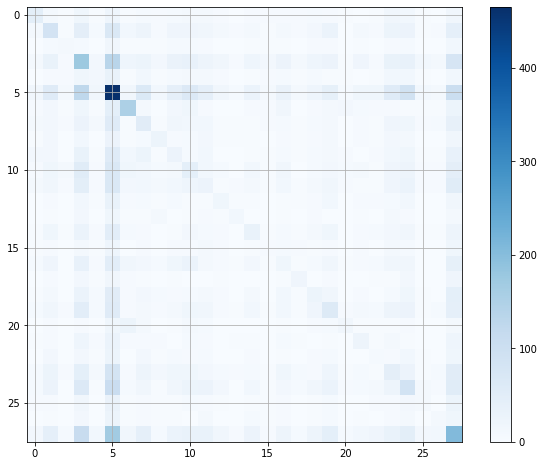

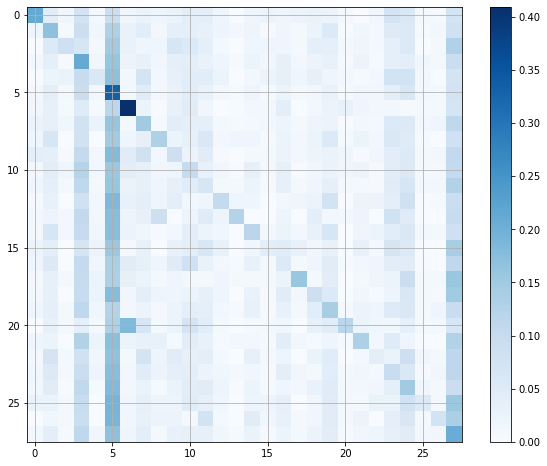

In [201]:
plot_confusion_matrix(labels_1hot, predicted, classes=tag_mbz,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=tag_mbz, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 2: Tag EchoNest 

The experiment is the same, but applied to the 10 subgenre classes.

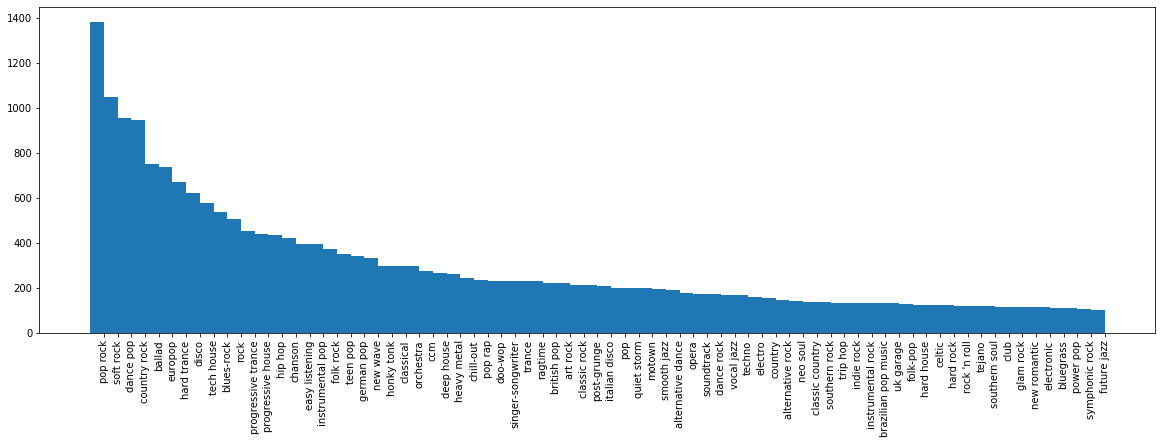

Distinct tag EchoNest considered:


74

In [202]:
data_filtered, tag_echo_filtered = clean_and_filter(tag_echo, 100)

print('Distinct tag EchoNest considered:')
len(np.unique(tag_echo_filtered))

In [204]:
print('Total elements:')
len(data_filtered)

Total elements:


21895

In [205]:
labels_1hot = onehot_labels(tag_echo_filtered)
    
onehot2str(labels_1hot[0])

'rock'

In [206]:
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 74)

In [207]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [208]:
scores = cross_val_score(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

Epoch 1/100
19705/19705 [==============================] - 2s 91us/sample - loss: 0.0709 - acc: 0.9854
Epoch 2/100
19705/19705 [==============================] - 1s 74us/sample - loss: 0.0643 - acc: 0.9865
Epoch 3/100
19705/19705 [==============================] - 2s 80us/sample - loss: 0.0636 - acc: 0.9865
Epoch 4/100
19705/19705 [==============================] - 2s 98us/sample - loss: 0.0630 - acc: 0.9865
Epoch 5/100
19705/19705 [==============================] - 2s 94us/sample - loss: 0.0626 - acc: 0.9866
Epoch 6/100
19705/19705 [==============================] - 2s 89us/sample - loss: 0.0622 - acc: 0.9865
Epoch 7/100
19705/19705 [==============================] - 2s 89us/sample - loss: 0.0617 - acc: 0.9865
Epoch 8/100
19705/19705 [==============================] - 2s 81us/sample - loss: 0.0614 - acc: 0.9866
Epoch 9/100
19705/19705 [==============================] - 2s 77us/sample - loss: 0.0610 - acc: 0.9866
Epoch 10/100
19705/19705 [==============================] - 1s 73us/sampl

19705/19705 [==============================] - 1s 75us/sample - loss: 0.0572 - acc: 0.9870
Epoch 80/100
19705/19705 [==============================] - 2s 88us/sample - loss: 0.0572 - acc: 0.9870
Epoch 81/100
19705/19705 [==============================] - 2s 103us/sample - loss: 0.0575 - acc: 0.9870
Epoch 82/100
19705/19705 [==============================] - 2s 96us/sample - loss: 0.0576 - acc: 0.9870
Epoch 83/100
19705/19705 [==============================] - 2s 93us/sample - loss: 0.0572 - acc: 0.9870
Epoch 84/100
19705/19705 [==============================] - 2s 95us/sample - loss: 0.0574 - acc: 0.9870
Epoch 85/100
19705/19705 [==============================] - 2s 110us/sample - loss: 0.0574 - acc: 0.9870
Epoch 86/100
19705/19705 [==============================] - 2s 89us/sample - loss: 0.0576 - acc: 0.9870
Epoch 87/100
19705/19705 [==============================] - 2s 92us/sample - loss: 0.0573 - acc: 0.9871
Epoch 88/100
19705/19705 [==============================] - 2s 82us/sample 

19705/19705 [==============================] - 2s 84us/sample - loss: 0.0567 - acc: 0.9870
Epoch 58/100
19705/19705 [==============================] - 2s 115us/sample - loss: 0.0566 - acc: 0.9870s - loss: 0.0565 - acc: 0
Epoch 59/100
19705/19705 [==============================] - 2s 103us/sample - loss: 0.0568 - acc: 0.9870
Epoch 60/100
19705/19705 [==============================] - 2s 86us/sample - loss: 0.0568 - acc: 0.9870
Epoch 61/100
19705/19705 [==============================] - 2s 84us/sample - loss: 0.0567 - acc: 0.9871
Epoch 62/100
19705/19705 [==============================] - 2s 85us/sample - loss: 0.0566 - acc: 0.9870
Epoch 63/100
19705/19705 [==============================] - 2s 82us/sample - loss: 0.0564 - acc: 0.9871
Epoch 64/100
19705/19705 [==============================] - 2s 82us/sample - loss: 0.0565 - acc: 0.9870
Epoch 65/100
19705/19705 [==============================] - 2s 87us/sample - loss: 0.0566 - acc: 0.9871
Epoch 66/100
19705/19705 [========================

19705/19705 [==============================] - 1s 66us/sample - loss: 0.0578 - acc: 0.9869
Epoch 35/100
19705/19705 [==============================] - 1s 68us/sample - loss: 0.0577 - acc: 0.9869
Epoch 36/100
19705/19705 [==============================] - 1s 69us/sample - loss: 0.0577 - acc: 0.9869
Epoch 37/100
19705/19705 [==============================] - 1s 68us/sample - loss: 0.0579 - acc: 0.9869
Epoch 38/100
19705/19705 [==============================] - 1s 67us/sample - loss: 0.0579 - acc: 0.9869
Epoch 39/100
19705/19705 [==============================] - 1s 67us/sample - loss: 0.0576 - acc: 0.9869
Epoch 40/100
19705/19705 [==============================] - 1s 65us/sample - loss: 0.0575 - acc: 0.9869
Epoch 41/100
19705/19705 [==============================] - 1s 66us/sample - loss: 0.0574 - acc: 0.9869
Epoch 42/100
19705/19705 [==============================] - 1s 65us/sample - loss: 0.0575 - acc: 0.9869
Epoch 43/100
19705/19705 [==============================] - 1s 66us/sample - 

19705/19705 [==============================] - 1s 63us/sample - loss: 0.0597 - acc: 0.9867
Epoch 13/100
19705/19705 [==============================] - 1s 65us/sample - loss: 0.0595 - acc: 0.9867
Epoch 14/100
19705/19705 [==============================] - 1s 66us/sample - loss: 0.0593 - acc: 0.9867
Epoch 15/100
19705/19705 [==============================] - 1s 63us/sample - loss: 0.0591 - acc: 0.9867
Epoch 16/100
19705/19705 [==============================] - 1s 62us/sample - loss: 0.0588 - acc: 0.9867
Epoch 17/100
19705/19705 [==============================] - 1s 63us/sample - loss: 0.0587 - acc: 0.9868
Epoch 18/100
19705/19705 [==============================] - 1s 62us/sample - loss: 0.0585 - acc: 0.9868
Epoch 19/100
19705/19705 [==============================] - 1s 67us/sample - loss: 0.0584 - acc: 0.9868
Epoch 20/100
19705/19705 [==============================] - 1s 65us/sample - loss: 0.0583 - acc: 0.9868
Epoch 21/100
19705/19705 [==============================] - 1s 66us/sample - 

19705/19705 [==============================] - 1s 64us/sample - loss: 0.0567 - acc: 0.9871
Epoch 91/100
19705/19705 [==============================] - 1s 66us/sample - loss: 0.0565 - acc: 0.9871
Epoch 92/100
19705/19705 [==============================] - 1s 66us/sample - loss: 0.0567 - acc: 0.9871
Epoch 93/100
19705/19705 [==============================] - 1s 75us/sample - loss: 0.0569 - acc: 0.9870
Epoch 94/100
19705/19705 [==============================] - 1s 71us/sample - loss: 0.0568 - acc: 0.9871
Epoch 95/100
19705/19705 [==============================] - 1s 69us/sample - loss: 0.0568 - acc: 0.9871
Epoch 96/100
19705/19705 [==============================] - 1s 67us/sample - loss: 0.0563 - acc: 0.9871
Epoch 97/100
19705/19705 [==============================] - 1s 64us/sample - loss: 0.0562 - acc: 0.9871
Epoch 98/100
19705/19705 [==============================] - 1s 63us/sample - loss: 0.0566 - acc: 0.9871
Epoch 99/100
19705/19705 [==============================] - 1s 68us/sample - 

19705/19705 [==============================] - 1s 61us/sample - loss: 0.0571 - acc: 0.9870
Epoch 69/100
19705/19705 [==============================] - 1s 66us/sample - loss: 0.0569 - acc: 0.9870
Epoch 70/100
19705/19705 [==============================] - 1s 66us/sample - loss: 0.0570 - acc: 0.9870
Epoch 71/100
19705/19705 [==============================] - 1s 62us/sample - loss: 0.0571 - acc: 0.9870
Epoch 72/100
19705/19705 [==============================] - 1s 62us/sample - loss: 0.0572 - acc: 0.9870
Epoch 73/100
19705/19705 [==============================] - 1s 73us/sample - loss: 0.0571 - acc: 0.9871
Epoch 74/100
19705/19705 [==============================] - 1s 62us/sample - loss: 0.0570 - acc: 0.9870
Epoch 75/100
19705/19705 [==============================] - 1s 69us/sample - loss: 0.0570 - acc: 0.9871
Epoch 76/100
19705/19705 [==============================] - 1s 73us/sample - loss: 0.0571 - acc: 0.9870
Epoch 77/100
19705/19705 [==============================] - 1s 71us/sample - 

19706/19706 [==============================] - 1s 69us/sample - loss: 0.0577 - acc: 0.9869
Epoch 47/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0577 - acc: 0.9869
Epoch 48/100
19706/19706 [==============================] - 1s 72us/sample - loss: 0.0577 - acc: 0.9869
Epoch 49/100
19706/19706 [==============================] - 1s 69us/sample - loss: 0.0576 - acc: 0.9869
Epoch 50/100
19706/19706 [==============================] - 1s 69us/sample - loss: 0.0575 - acc: 0.9869
Epoch 51/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0576 - acc: 0.9869
Epoch 52/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0575 - acc: 0.9869
Epoch 53/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0575 - acc: 0.9869
Epoch 54/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0576 - acc: 0.9869
Epoch 55/100
19706/19706 [==============================] - 1s 71us/sample - 

19706/19706 [==============================] - 2s 82us/sample - loss: 0.0578 - acc: 0.9868
Epoch 24/100
19706/19706 [==============================] - 2s 81us/sample - loss: 0.0577 - acc: 0.9868
Epoch 25/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0576 - acc: 0.9869
Epoch 26/100
19706/19706 [==============================] - 1s 73us/sample - loss: 0.0574 - acc: 0.9869
Epoch 27/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0574 - acc: 0.9869
Epoch 28/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0573 - acc: 0.9869
Epoch 29/100
19706/19706 [==============================] - 1s 72us/sample - loss: 0.0573 - acc: 0.9869
Epoch 30/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0573 - acc: 0.9869
Epoch 31/100
19706/19706 [==============================] - 1s 73us/sample - loss: 0.0575 - acc: 0.9869
Epoch 32/100
19706/19706 [==============================] - 1s 74us/sample - 

2189/2189 [==============================] - 0s 174us/sample - loss: 0.0903 - acc: 0.9858
Epoch 1/100
19706/19706 [==============================] - 2s 88us/sample - loss: 0.0707 - acc: 0.9855
Epoch 2/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0643 - acc: 0.9865
Epoch 3/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0633 - acc: 0.9865
Epoch 4/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0628 - acc: 0.9865
Epoch 5/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0623 - acc: 0.9865
Epoch 6/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0619 - acc: 0.9866
Epoch 7/100
19706/19706 [==============================] - 1s 72us/sample - loss: 0.0614 - acc: 0.9866
Epoch 8/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0611 - acc: 0.9866
Epoch 9/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.06

Epoch 79/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0568 - acc: 0.9870
Epoch 80/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0567 - acc: 0.9871
Epoch 81/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0564 - acc: 0.9871
Epoch 82/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0567 - acc: 0.9871
Epoch 83/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0570 - acc: 0.9870
Epoch 84/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0569 - acc: 0.9871
Epoch 85/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0570 - acc: 0.9871
Epoch 86/100
19706/19706 [==============================] - 1s 71us/sample - loss: 0.0568 - acc: 0.9871
Epoch 87/100
19706/19706 [==============================] - 1s 70us/sample - loss: 0.0569 - acc: 0.9871
Epoch 88/100
19706/19706 [==============================] - 1s 7

Epoch 57/100
19706/19706 [==============================] - 1s 73us/sample - loss: 0.0568 - acc: 0.9870
Epoch 58/100
19706/19706 [==============================] - 1s 72us/sample - loss: 0.0569 - acc: 0.9870
Epoch 59/100
19706/19706 [==============================] - 1s 72us/sample - loss: 0.0570 - acc: 0.9869
Epoch 60/100
19706/19706 [==============================] - 1s 72us/sample - loss: 0.0570 - acc: 0.9869
Epoch 61/100
19706/19706 [==============================] - 1s 72us/sample - loss: 0.0570 - acc: 0.9870
Epoch 62/100
19706/19706 [==============================] - 1s 73us/sample - loss: 0.0568 - acc: 0.9870
Epoch 63/100
19706/19706 [==============================] - 1s 73us/sample - loss: 0.0567 - acc: 0.9870
Epoch 64/100
19706/19706 [==============================] - 1s 74us/sample - loss: 0.0570 - acc: 0.9870
Epoch 65/100
19706/19706 [==============================] - 1s 73us/sample - loss: 0.0570 - acc: 0.9869
Epoch 66/100
19706/19706 [==============================] - 1s 7

Epoch 35/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0575 - acc: 0.9869
Epoch 36/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0573 - acc: 0.9870
Epoch 37/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0573 - acc: 0.9870
Epoch 38/100
19706/19706 [==============================] - 1s 76us/sample - loss: 0.0573 - acc: 0.9870
Epoch 39/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0572 - acc: 0.9870
Epoch 40/100
19706/19706 [==============================] - 2s 76us/sample - loss: 0.0573 - acc: 0.9870
Epoch 41/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0571 - acc: 0.9870
Epoch 42/100
19706/19706 [==============================] - 1s 76us/sample - loss: 0.0572 - acc: 0.9870
Epoch 43/100
19706/19706 [==============================] - 1s 75us/sample - loss: 0.0571 - acc: 0.9870
Epoch 44/100
19706/19706 [==============================] - 1s 7

array([0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99])

In [209]:
np.mean(scores)

0.9859248876571656

In [210]:
predicted = cross_val_predict(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

Epoch 1/100
19705/19705 [==============================] - 2s 95us/sample - loss: 0.0707 - acc: 0.9854
Epoch 2/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0644 - acc: 0.9865
Epoch 3/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0635 - acc: 0.9865
Epoch 4/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0629 - acc: 0.9865
Epoch 5/100
19705/19705 [==============================] - 2s 77us/sample - loss: 0.0626 - acc: 0.9865
Epoch 6/100
19705/19705 [==============================] - 2s 79us/sample - loss: 0.0621 - acc: 0.9866
Epoch 7/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0618 - acc: 0.9865
Epoch 8/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0615 - acc: 0.9866
Epoch 9/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0612 - acc: 0.9866
Epoch 10/100
19705/19705 [==============================] - 2s 78us/sampl

19705/19705 [==============================] - 2s 76us/sample - loss: 0.0577 - acc: 0.9869
Epoch 80/100
19705/19705 [==============================] - 2s 76us/sample - loss: 0.0579 - acc: 0.9870
Epoch 81/100
19705/19705 [==============================] - 2s 77us/sample - loss: 0.0578 - acc: 0.9869
Epoch 82/100
19705/19705 [==============================] - 2s 77us/sample - loss: 0.0580 - acc: 0.9870
Epoch 83/100
19705/19705 [==============================] - 2s 77us/sample - loss: 0.0578 - acc: 0.9870
Epoch 84/100
19705/19705 [==============================] - 2s 77us/sample - loss: 0.0575 - acc: 0.9870
Epoch 85/100
19705/19705 [==============================] - 2s 77us/sample - loss: 0.0578 - acc: 0.9870
Epoch 86/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0577 - acc: 0.9870
Epoch 87/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0578 - acc: 0.9870
Epoch 88/100
19705/19705 [==============================] - 2s 78us/sample - 

19705/19705 [==============================] - 2s 79us/sample - loss: 0.0571 - acc: 0.9870
Epoch 58/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0572 - acc: 0.9870
Epoch 59/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0575 - acc: 0.9870
Epoch 60/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0576 - acc: 0.9870
Epoch 61/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0572 - acc: 0.9870
Epoch 62/100
19705/19705 [==============================] - 2s 79us/sample - loss: 0.0574 - acc: 0.9870
Epoch 63/100
19705/19705 [==============================] - 2s 79us/sample - loss: 0.0572 - acc: 0.9870
Epoch 64/100
19705/19705 [==============================] - 2s 78us/sample - loss: 0.0571 - acc: 0.9870
Epoch 65/100
19705/19705 [==============================] - 2s 79us/sample - loss: 0.0572 - acc: 0.9870
Epoch 66/100
19705/19705 [==============================] - 2s 79us/sample - 

19705/19705 [==============================] - 2s 80us/sample - loss: 0.0580 - acc: 0.9868
Epoch 36/100
19705/19705 [==============================] - 2s 80us/sample - loss: 0.0580 - acc: 0.9868
Epoch 37/100
19705/19705 [==============================] - 2s 80us/sample - loss: 0.0577 - acc: 0.9869
Epoch 38/100
19705/19705 [==============================] - 2s 80us/sample - loss: 0.0579 - acc: 0.9869
Epoch 39/100
19705/19705 [==============================] - 2s 80us/sample - loss: 0.0579 - acc: 0.9868
Epoch 40/100
19705/19705 [==============================] - 2s 81us/sample - loss: 0.0579 - acc: 0.9869
Epoch 41/100
19705/19705 [==============================] - 2s 80us/sample - loss: 0.0578 - acc: 0.9869
Epoch 42/100
19705/19705 [==============================] - 2s 80us/sample - loss: 0.0577 - acc: 0.9869
Epoch 43/100
19705/19705 [==============================] - 2s 81us/sample - loss: 0.0578 - acc: 0.9869
Epoch 44/100
19705/19705 [==============================] - 2s 80us/sample - 

19705/19705 [==============================] - 2s 82us/sample - loss: 0.0596 - acc: 0.9867
Epoch 14/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0594 - acc: 0.9867
Epoch 15/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0591 - acc: 0.9867
Epoch 16/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0589 - acc: 0.9867
Epoch 17/100
19705/19705 [==============================] - 2s 82us/sample - loss: 0.0588 - acc: 0.9868
Epoch 18/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0586 - acc: 0.9868
Epoch 19/100
19705/19705 [==============================] - 2s 82us/sample - loss: 0.0585 - acc: 0.9868
Epoch 20/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0583 - acc: 0.9868
Epoch 21/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0583 - acc: 0.9868
Epoch 22/100
19705/19705 [==============================] - 2s 83us/sample - 

19705/19705 [==============================] - 2s 83us/sample - loss: 0.0565 - acc: 0.9871
Epoch 92/100
19705/19705 [==============================] - 2s 82us/sample - loss: 0.0569 - acc: 0.9871
Epoch 93/100
19705/19705 [==============================] - 2s 82us/sample - loss: 0.0566 - acc: 0.9871
Epoch 94/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0565 - acc: 0.9871
Epoch 95/100
19705/19705 [==============================] - 2s 82us/sample - loss: 0.0566 - acc: 0.9871
Epoch 96/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0564 - acc: 0.9871
Epoch 97/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0562 - acc: 0.9872
Epoch 98/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0565 - acc: 0.9871
Epoch 99/100
19705/19705 [==============================] - 2s 83us/sample - loss: 0.0566 - acc: 0.9871
Epoch 100/100
19705/19705 [==============================] - 2s 83us/sample -

19705/19705 [==============================] - 2s 118us/sample - loss: 0.0574 - acc: 0.9870
Epoch 70/100
19705/19705 [==============================] - 2s 109us/sample - loss: 0.0573 - acc: 0.9870
Epoch 71/100
19705/19705 [==============================] - 2s 94us/sample - loss: 0.0574 - acc: 0.98700s - loss: 0.
Epoch 72/100
19705/19705 [==============================] - 2s 91us/sample - loss: 0.0572 - acc: 0.9870
Epoch 73/100
19705/19705 [==============================] - 2s 93us/sample - loss: 0.0571 - acc: 0.9870
Epoch 74/100
19705/19705 [==============================] - 2s 98us/sample - loss: 0.0571 - acc: 0.9870
Epoch 75/100
19705/19705 [==============================] - 2s 98us/sample - loss: 0.0572 - acc: 0.9870
Epoch 76/100
19705/19705 [==============================] - 3s 130us/sample - loss: 0.0574 - acc: 0.9870
Epoch 77/100
19705/19705 [==============================] - 3s 143us/sample - loss: 0.0572 - acc: 0.9870
Epoch 78/100
19705/19705 [==============================] - 

19706/19706 [==============================] - 2s 121us/sample - loss: 0.0567 - acc: 0.9870
Epoch 48/100
19706/19706 [==============================] - 2s 106us/sample - loss: 0.0568 - acc: 0.9870
Epoch 49/100
19706/19706 [==============================] - 2s 92us/sample - loss: 0.0565 - acc: 0.9871
Epoch 50/100
19706/19706 [==============================] - 2s 94us/sample - loss: 0.0565 - acc: 0.9871
Epoch 51/100
19706/19706 [==============================] - 2s 97us/sample - loss: 0.0566 - acc: 0.9871
Epoch 52/100
19706/19706 [==============================] - 2s 92us/sample - loss: 0.0566 - acc: 0.9871
Epoch 53/100
19706/19706 [==============================] - 2s 94us/sample - loss: 0.0565 - acc: 0.9871
Epoch 54/100
19706/19706 [==============================] - 2s 91us/sample - loss: 0.0567 - acc: 0.9871
Epoch 55/100
19706/19706 [==============================] - 2s 90us/sample - loss: 0.0566 - acc: 0.9871
Epoch 56/100
19706/19706 [==============================] - 2s 95us/sample 

19706/19706 [==============================] - 2s 97us/sample - loss: 0.0581 - acc: 0.9868
Epoch 26/100
19706/19706 [==============================] - 2s 113us/sample - loss: 0.0580 - acc: 0.9869
Epoch 27/100
19706/19706 [==============================] - 2s 100us/sample - loss: 0.0581 - acc: 0.9868
Epoch 28/100
19706/19706 [==============================] - 2s 107us/sample - loss: 0.0580 - acc: 0.9869
Epoch 29/100
19706/19706 [==============================] - 3s 170us/sample - loss: 0.0579 - acc: 0.9868
Epoch 30/100
19706/19706 [==============================] - 2s 107us/sample - loss: 0.0579 - acc: 0.9869
Epoch 31/100
19706/19706 [==============================] - 2s 99us/sample - loss: 0.0577 - acc: 0.9869
Epoch 32/100
19706/19706 [==============================] - 2s 101us/sample - loss: 0.0580 - acc: 0.9869
Epoch 33/100
19706/19706 [==============================] - 2s 98us/sample - loss: 0.0579 - acc: 0.9869
Epoch 34/100
19706/19706 [==============================] - 2s 99us/sam

19706/19706 [==============================] - 2s 101us/sample - loss: 0.0633 - acc: 0.9865
Epoch 4/100
19706/19706 [==============================] - 2s 99us/sample - loss: 0.0627 - acc: 0.9866
Epoch 5/100
19706/19706 [==============================] - 2s 100us/sample - loss: 0.0623 - acc: 0.9866
Epoch 6/100
19706/19706 [==============================] - 2s 106us/sample - loss: 0.0618 - acc: 0.9866
Epoch 7/100
19706/19706 [==============================] - 2s 105us/sample - loss: 0.0614 - acc: 0.9866
Epoch 8/100
19706/19706 [==============================] - 2s 103us/sample - loss: 0.0610 - acc: 0.9866
Epoch 9/100
19706/19706 [==============================] - 2s 103us/sample - loss: 0.0605 - acc: 0.9866
Epoch 10/100
19706/19706 [==============================] - 2s 100us/sample - loss: 0.0602 - acc: 0.9867
Epoch 11/100
19706/19706 [==============================] - 2s 101us/sample - loss: 0.0599 - acc: 0.9867
Epoch 12/100
19706/19706 [==============================] - 2s 98us/sample 

19706/19706 [==============================] - 2s 96us/sample - loss: 0.0564 - acc: 0.9871
Epoch 82/100
19706/19706 [==============================] - 2s 97us/sample - loss: 0.0565 - acc: 0.9871
Epoch 83/100
19706/19706 [==============================] - 2s 97us/sample - loss: 0.0564 - acc: 0.9871
Epoch 84/100
19706/19706 [==============================] - 2s 101us/sample - loss: 0.0563 - acc: 0.9871
Epoch 85/100
19706/19706 [==============================] - 2s 122us/sample - loss: 0.0562 - acc: 0.9872
Epoch 86/100
19706/19706 [==============================] - 2s 92us/sample - loss: 0.0566 - acc: 0.9871
Epoch 87/100
19706/19706 [==============================] - 2s 87us/sample - loss: 0.0562 - acc: 0.9871
Epoch 88/100
19706/19706 [==============================] - 2s 88us/sample - loss: 0.0563 - acc: 0.9872
Epoch 89/100
19706/19706 [==============================] - 2s 88us/sample - loss: 0.0563 - acc: 0.9871
Epoch 90/100
19706/19706 [==============================] - 2s 95us/sample 

19706/19706 [==============================] - 2s 105us/sample - loss: 0.0571 - acc: 0.9871
Epoch 60/100
19706/19706 [==============================] - 2s 105us/sample - loss: 0.0572 - acc: 0.9870
Epoch 61/100
19706/19706 [==============================] - 2s 111us/sample - loss: 0.0572 - acc: 0.9870
Epoch 62/100
19706/19706 [==============================] - 3s 131us/sample - loss: 0.0573 - acc: 0.9870
Epoch 63/100
19706/19706 [==============================] - 2s 117us/sample - loss: 0.0570 - acc: 0.9871
Epoch 64/100
19706/19706 [==============================] - 2s 103us/sample - loss: 0.0572 - acc: 0.9871
Epoch 65/100
19706/19706 [==============================] - 3s 128us/sample - loss: 0.0573 - acc: 0.9870
Epoch 66/100
19706/19706 [==============================] - 2s 106us/sample - loss: 0.0569 - acc: 0.9871
Epoch 67/100
19706/19706 [==============================] - 2s 102us/sample - loss: 0.0571 - acc: 0.9871
Epoch 68/100
19706/19706 [==============================] - 2s 102us

19706/19706 [==============================] - 2s 98us/sample - loss: 0.0574 - acc: 0.9869
Epoch 38/100
19706/19706 [==============================] - 2s 97us/sample - loss: 0.0576 - acc: 0.9869
Epoch 39/100
19706/19706 [==============================] - 2s 97us/sample - loss: 0.0576 - acc: 0.9869
Epoch 40/100
19706/19706 [==============================] - 2s 98us/sample - loss: 0.0574 - acc: 0.9869
Epoch 41/100
19706/19706 [==============================] - 2s 98us/sample - loss: 0.0574 - acc: 0.9869
Epoch 42/100
19706/19706 [==============================] - 2s 98us/sample - loss: 0.0573 - acc: 0.9869
Epoch 43/100
19706/19706 [==============================] - 2s 99us/sample - loss: 0.0573 - acc: 0.9869
Epoch 44/100
19706/19706 [==============================] - 2s 98us/sample - loss: 0.0573 - acc: 0.9869
Epoch 45/100
19706/19706 [==============================] - 2s 98us/sample - loss: 0.0572 - acc: 0.9869
Epoch 46/100
19706/19706 [==============================] - 2s 98us/sample - 

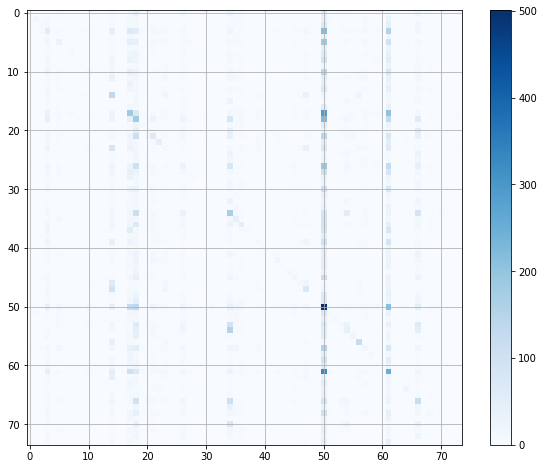

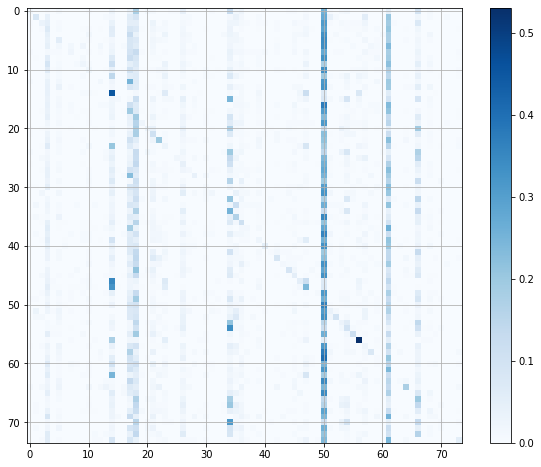

In [212]:
plot_confusion_matrix(labels_1hot, predicted, classes=tag_echo,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(labels_1hot, predicted, classes=tag_echo, normalize=True,
                      title='Normalized confusion matrix')

### Experiment 3: Year

In [218]:
year_filtered

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U4')

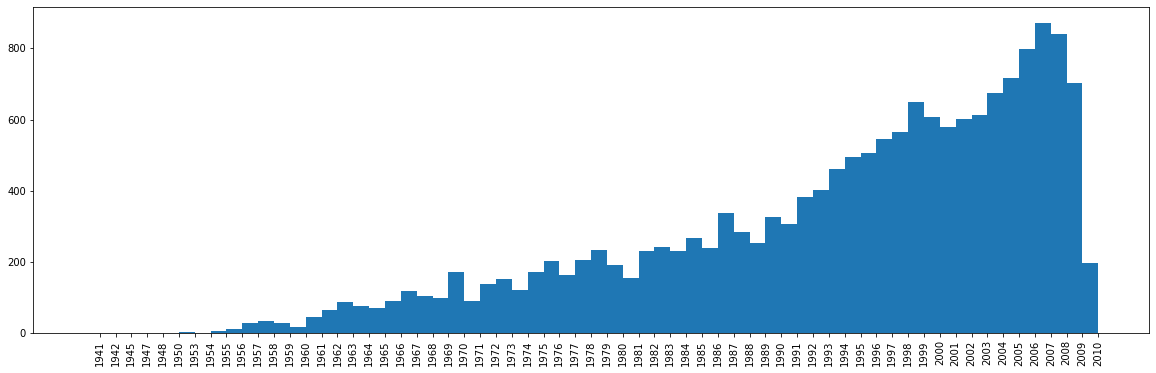

Distinct year considered:


64

In [228]:
data_filtered, year_filtered = clean_and_filter(year, 0, sort_by='key')

print('Distinct year considered:')
len(np.unique(year_filtered))

In [229]:
print('Total elements:')
len(data_filtered)

Total elements:


16834

In [231]:
labels_1hot = onehot_labels(year_filtered)
    
onehot2str(labels_1hot[0])

'2004'

In [232]:
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 64)

In [233]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32)

In [234]:
scores = cross_val_score(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

Epoch 1/100
15150/15150 [==============================] - 2s 129us/sample - loss: 0.0794 - acc: 0.9832
Epoch 2/100
15150/15150 [==============================] - 2s 106us/sample - loss: 0.0733 - acc: 0.9844
Epoch 3/100
15150/15150 [==============================] - 2s 100us/sample - loss: 0.0723 - acc: 0.9844
Epoch 4/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0716 - acc: 0.9844
Epoch 5/100
15150/15150 [==============================] - 2s 104us/sample - loss: 0.0710 - acc: 0.9844
Epoch 6/100
15150/15150 [==============================] - 2s 104us/sample - loss: 0.0704 - acc: 0.9844
Epoch 7/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0699 - acc: 0.9844
Epoch 8/100
15150/15150 [==============================] - 2s 105us/sample - loss: 0.0694 - acc: 0.9844
Epoch 9/100
15150/15150 [==============================] - 2s 103us/sample - loss: 0.0688 - acc: 0.9845
Epoch 10/100
15150/15150 [==============================] - 2s 1

15150/15150 [==============================] - 1s 95us/sample - loss: 0.0605 - acc: 0.9852
Epoch 80/100
15150/15150 [==============================] - 1s 96us/sample - loss: 0.0607 - acc: 0.9852
Epoch 81/100
15150/15150 [==============================] - 1s 96us/sample - loss: 0.0606 - acc: 0.9852
Epoch 82/100
15150/15150 [==============================] - 1s 98us/sample - loss: 0.0603 - acc: 0.9852
Epoch 83/100
15150/15150 [==============================] - 1s 97us/sample - loss: 0.0603 - acc: 0.9853
Epoch 84/100
15150/15150 [==============================] - 1s 97us/sample - loss: 0.0605 - acc: 0.9852
Epoch 85/100
15150/15150 [==============================] - 1s 97us/sample - loss: 0.0609 - acc: 0.9852
Epoch 86/100
15150/15150 [==============================] - 1s 96us/sample - loss: 0.0602 - acc: 0.9853
Epoch 87/100
15150/15150 [==============================] - 1s 96us/sample - loss: 0.0603 - acc: 0.9853
Epoch 88/100
15150/15150 [==============================] - 1s 97us/sample - 

15150/15150 [==============================] - 1s 98us/sample - loss: 0.0611 - acc: 0.9851
Epoch 57/100
15150/15150 [==============================] - 1s 98us/sample - loss: 0.0613 - acc: 0.9852
Epoch 58/100
15150/15150 [==============================] - 1s 98us/sample - loss: 0.0613 - acc: 0.9852
Epoch 59/100
15150/15150 [==============================] - 1s 98us/sample - loss: 0.0613 - acc: 0.9852
Epoch 60/100
15150/15150 [==============================] - 1s 99us/sample - loss: 0.0611 - acc: 0.9852
Epoch 61/100
15150/15150 [==============================] - 1s 99us/sample - loss: 0.0613 - acc: 0.9852
Epoch 62/100
15150/15150 [==============================] - 1s 98us/sample - loss: 0.0614 - acc: 0.9852
Epoch 63/100
15150/15150 [==============================] - 1s 98us/sample - loss: 0.0612 - acc: 0.9852
Epoch 64/100
15150/15150 [==============================] - 1s 98us/sample - loss: 0.0609 - acc: 0.9852
Epoch 65/100
15150/15150 [==============================] - 1s 99us/sample - 

15150/15150 [==============================] - 2s 100us/sample - loss: 0.0622 - acc: 0.9850
Epoch 34/100
15150/15150 [==============================] - 2s 100us/sample - loss: 0.0625 - acc: 0.9849
Epoch 35/100
15150/15150 [==============================] - 2s 100us/sample - loss: 0.0622 - acc: 0.9850
Epoch 36/100
15150/15150 [==============================] - 2s 101us/sample - loss: 0.0621 - acc: 0.9850
Epoch 37/100
15150/15150 [==============================] - 2s 100us/sample - loss: 0.0618 - acc: 0.9851
Epoch 38/100
15150/15150 [==============================] - 2s 100us/sample - loss: 0.0622 - acc: 0.9850
Epoch 39/100
15150/15150 [==============================] - 2s 100us/sample - loss: 0.0618 - acc: 0.9851
Epoch 40/100
15150/15150 [==============================] - 2s 100us/sample - loss: 0.0618 - acc: 0.9851
Epoch 41/100
15150/15150 [==============================] - 2s 101us/sample - loss: 0.0617 - acc: 0.9851
Epoch 42/100
15150/15150 [==============================] - 2s 101us

15150/15150 [==============================] - 2s 103us/sample - loss: 0.0685 - acc: 0.9845
Epoch 11/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0680 - acc: 0.9845
Epoch 12/100
15150/15150 [==============================] - 2s 103us/sample - loss: 0.0675 - acc: 0.9846
Epoch 13/100
15150/15150 [==============================] - 2s 104us/sample - loss: 0.0672 - acc: 0.9846
Epoch 14/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0666 - acc: 0.9846
Epoch 15/100
15150/15150 [==============================] - 2s 103us/sample - loss: 0.0663 - acc: 0.9846
Epoch 16/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0660 - acc: 0.9847
Epoch 17/100
15150/15150 [==============================] - 2s 103us/sample - loss: 0.0657 - acc: 0.9847
Epoch 18/100
15150/15150 [==============================] - 2s 104us/sample - loss: 0.0653 - acc: 0.9847
Epoch 19/100
15150/15150 [==============================] - 2s 103us

15150/15150 [==============================] - 2s 101us/sample - loss: 0.0609 - acc: 0.9853
Epoch 89/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0606 - acc: 0.9854
Epoch 90/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0603 - acc: 0.9854
Epoch 91/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0604 - acc: 0.9854
Epoch 92/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0602 - acc: 0.9854
Epoch 93/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0600 - acc: 0.9855
Epoch 94/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0607 - acc: 0.9854
Epoch 95/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0608 - acc: 0.9853
Epoch 96/100
15150/15150 [==============================] - 2s 102us/sample - loss: 0.0607 - acc: 0.9854
Epoch 97/100
15150/15150 [==============================] - 2s 103us

15151/15151 [==============================] - 2s 103us/sample - loss: 0.0596 - acc: 0.9854
Epoch 66/100
15151/15151 [==============================] - 2s 105us/sample - loss: 0.0597 - acc: 0.9853
Epoch 67/100
15151/15151 [==============================] - 2s 105us/sample - loss: 0.0594 - acc: 0.9854
Epoch 68/100
15151/15151 [==============================] - 2s 105us/sample - loss: 0.0591 - acc: 0.9854
Epoch 69/100
15151/15151 [==============================] - 2s 105us/sample - loss: 0.0593 - acc: 0.9854
Epoch 70/100
15151/15151 [==============================] - 2s 104us/sample - loss: 0.0595 - acc: 0.9854
Epoch 71/100
15151/15151 [==============================] - 2s 104us/sample - loss: 0.0589 - acc: 0.9855
Epoch 72/100
15151/15151 [==============================] - 2s 105us/sample - loss: 0.0590 - acc: 0.9854
Epoch 73/100
15151/15151 [==============================] - 2s 105us/sample - loss: 0.0591 - acc: 0.9854
Epoch 74/100
15151/15151 [==============================] - 2s 105us

15151/15151 [==============================] - 2s 106us/sample - loss: 0.0616 - acc: 0.9851
Epoch 43/100
15151/15151 [==============================] - 2s 106us/sample - loss: 0.0615 - acc: 0.9850
Epoch 44/100
15151/15151 [==============================] - 2s 105us/sample - loss: 0.0617 - acc: 0.9851
Epoch 45/100
15151/15151 [==============================] - 2s 106us/sample - loss: 0.0612 - acc: 0.9851
Epoch 46/100
15151/15151 [==============================] - 2s 107us/sample - loss: 0.0612 - acc: 0.9851
Epoch 47/100
15151/15151 [==============================] - 2s 106us/sample - loss: 0.0614 - acc: 0.9851
Epoch 48/100
15151/15151 [==============================] - 2s 107us/sample - loss: 0.0613 - acc: 0.9851
Epoch 49/100
15151/15151 [==============================] - 2s 108us/sample - loss: 0.0613 - acc: 0.9851
Epoch 50/100
15151/15151 [==============================] - 2s 107us/sample - loss: 0.0617 - acc: 0.9850
Epoch 51/100
15151/15151 [==============================] - 2s 107us

15151/15151 [==============================] - 2s 110us/sample - loss: 0.0638 - acc: 0.9848
Epoch 20/100
15151/15151 [==============================] - 2s 108us/sample - loss: 0.0634 - acc: 0.9849
Epoch 21/100
15151/15151 [==============================] - 2s 109us/sample - loss: 0.0634 - acc: 0.9848
Epoch 22/100
15151/15151 [==============================] - 2s 108us/sample - loss: 0.0630 - acc: 0.9849
Epoch 23/100
15151/15151 [==============================] - 2s 110us/sample - loss: 0.0631 - acc: 0.9848
Epoch 24/100
15151/15151 [==============================] - 2s 108us/sample - loss: 0.0626 - acc: 0.9849
Epoch 25/100
15151/15151 [==============================] - 2s 108us/sample - loss: 0.0624 - acc: 0.9849
Epoch 26/100
15151/15151 [==============================] - 2s 109us/sample - loss: 0.0623 - acc: 0.9849
Epoch 27/100
15151/15151 [==============================] - 2s 108us/sample - loss: 0.0623 - acc: 0.9850
Epoch 28/100
15151/15151 [==============================] - 2s 108us

15151/15151 [==============================] - 2s 108us/sample - loss: 0.0586 - acc: 0.9855
Epoch 98/100
15151/15151 [==============================] - 2s 108us/sample - loss: 0.0583 - acc: 0.9855
Epoch 99/100
15151/15151 [==============================] - 2s 109us/sample - loss: 0.0585 - acc: 0.9854
Epoch 100/100
1683/1683 [==============================] - 1s 301us/sample - loss: 0.1203 - acc: 0.9825
Epoch 1/100
15151/15151 [==============================] - 2s 139us/sample - loss: 0.0799 - acc: 0.9828
Epoch 2/100
15151/15151 [==============================] - 2s 111us/sample - loss: 0.0732 - acc: 0.9844
Epoch 3/100
15151/15151 [==============================] - 2s 111us/sample - loss: 0.0724 - acc: 0.9844
Epoch 4/100
15151/15151 [==============================] - 2s 111us/sample - loss: 0.0716 - acc: 0.9844
Epoch 5/100
15151/15151 [==============================] - 2s 111us/sample - loss: 0.0710 - acc: 0.9844
Epoch 6/100
15151/15151 [==============================] - 2s 112us/sample

15151/15151 [==============================] - 2s 109us/sample - loss: 0.0603 - acc: 0.9852
Epoch 75/100
15151/15151 [==============================] - 2s 110us/sample - loss: 0.0595 - acc: 0.9853
Epoch 76/100
15151/15151 [==============================] - 2s 110us/sample - loss: 0.0593 - acc: 0.9854
Epoch 77/100
15151/15151 [==============================] - 2s 111us/sample - loss: 0.0593 - acc: 0.9853
Epoch 78/100
15151/15151 [==============================] - 2s 110us/sample - loss: 0.0594 - acc: 0.9853
Epoch 79/100
15151/15151 [==============================] - 2s 111us/sample - loss: 0.0600 - acc: 0.9853
Epoch 80/100
15151/15151 [==============================] - 2s 110us/sample - loss: 0.0594 - acc: 0.9853
Epoch 81/100
15151/15151 [==============================] - 2s 110us/sample - loss: 0.0593 - acc: 0.9854
Epoch 82/100
15151/15151 [==============================] - 2s 109us/sample - loss: 0.0592 - acc: 0.9854
Epoch 83/100
15151/15151 [==============================] - 2s 111us

15151/15151 [==============================] - 2s 114us/sample - loss: 0.0607 - acc: 0.9852
Epoch 52/100
15151/15151 [==============================] - 2s 114us/sample - loss: 0.0607 - acc: 0.9852
Epoch 53/100
15151/15151 [==============================] - 2s 125us/sample - loss: 0.0602 - acc: 0.9853
Epoch 54/100
15151/15151 [==============================] - 2s 119us/sample - loss: 0.0601 - acc: 0.9853
Epoch 55/100
15151/15151 [==============================] - 2s 109us/sample - loss: 0.0599 - acc: 0.9853
Epoch 56/100
15151/15151 [==============================] - 2s 118us/sample - loss: 0.0600 - acc: 0.9853
Epoch 57/100
15151/15151 [==============================] - 2s 135us/sample - loss: 0.0598 - acc: 0.9853
Epoch 58/100
15151/15151 [==============================] - 2s 124us/sample - loss: 0.0603 - acc: 0.9852
Epoch 59/100
15151/15151 [==============================] - 2s 129us/sample - loss: 0.0599 - acc: 0.9853
Epoch 60/100
15151/15151 [==============================] - 2s 123us

15151/15151 [==============================] - 2s 128us/sample - loss: 0.0628 - acc: 0.9849
Epoch 29/100
15151/15151 [==============================] - 2s 123us/sample - loss: 0.0626 - acc: 0.9849
Epoch 30/100
15151/15151 [==============================] - 2s 124us/sample - loss: 0.0624 - acc: 0.9849
Epoch 31/100
15151/15151 [==============================] - 2s 144us/sample - loss: 0.0626 - acc: 0.9849
Epoch 32/100
15151/15151 [==============================] - 2s 139us/sample - loss: 0.0624 - acc: 0.9849
Epoch 33/100
15151/15151 [==============================] - 2s 128us/sample - loss: 0.0624 - acc: 0.9849
Epoch 34/100
15151/15151 [==============================] - 2s 134us/sample - loss: 0.0623 - acc: 0.9849
Epoch 35/100
15151/15151 [==============================] - 2s 127us/sample - loss: 0.0620 - acc: 0.9850
Epoch 36/100
15151/15151 [==============================] - 2s 129us/sample - loss: 0.0619 - acc: 0.9849
Epoch 37/100
15151/15151 [==============================] - 2s 121us

array([0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98])

In [235]:
np.mean(scores)

0.9829028725624085

In [236]:
predicted = cross_val_predict(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

Epoch 1/100
15150/15150 [==============================] - 2s 150us/sample - loss: 0.0797 - acc: 0.9830
Epoch 2/100
15150/15150 [==============================] - 2s 127us/sample - loss: 0.0733 - acc: 0.9844
Epoch 3/100
15150/15150 [==============================] - 2s 148us/sample - loss: 0.0723 - acc: 0.9844
Epoch 4/100
15150/15150 [==============================] - 2s 131us/sample - loss: 0.0717 - acc: 0.9844
Epoch 5/100
15150/15150 [==============================] - 2s 136us/sample - loss: 0.0711 - acc: 0.9844
Epoch 6/100
15150/15150 [==============================] - 2s 129us/sample - loss: 0.0705 - acc: 0.9844
Epoch 7/100
15150/15150 [==============================] - 2s 126us/sample - loss: 0.0698 - acc: 0.9844
Epoch 8/100
15150/15150 [==============================] - 2s 132us/sample - loss: 0.0693 - acc: 0.9844
Epoch 9/100
15150/15150 [==============================] - 2s 129us/sample - loss: 0.0688 - acc: 0.9845
Epoch 10/100
15150/15150 [==============================] - 3s 1

15150/15150 [==============================] - 2s 126us/sample - loss: 0.0601 - acc: 0.9852
Epoch 80/100
15150/15150 [==============================] - 2s 123us/sample - loss: 0.0600 - acc: 0.9853
Epoch 81/100
15150/15150 [==============================] - 2s 126us/sample - loss: 0.0599 - acc: 0.9853
Epoch 82/100
15150/15150 [==============================] - 2s 126us/sample - loss: 0.0600 - acc: 0.9853
Epoch 83/100
15150/15150 [==============================] - 2s 131us/sample - loss: 0.0605 - acc: 0.9852
Epoch 84/100
15150/15150 [==============================] - 2s 131us/sample - loss: 0.0599 - acc: 0.9853
Epoch 85/100
15150/15150 [==============================] - 2s 132us/sample - loss: 0.0601 - acc: 0.9853
Epoch 86/100
15150/15150 [==============================] - 2s 133us/sample - loss: 0.0601 - acc: 0.9853
Epoch 87/100
15150/15150 [==============================] - 2s 135us/sample - loss: 0.0606 - acc: 0.9852
Epoch 88/100
15150/15150 [==============================] - 2s 132us

15150/15150 [==============================] - 2s 121us/sample - loss: 0.0615 - acc: 0.9851
Epoch 58/100
15150/15150 [==============================] - 2s 119us/sample - loss: 0.0614 - acc: 0.9851
Epoch 59/100
15150/15150 [==============================] - 2s 141us/sample - loss: 0.0617 - acc: 0.9851
Epoch 60/100
15150/15150 [==============================] - 2s 129us/sample - loss: 0.0618 - acc: 0.9850
Epoch 61/100
15150/15150 [==============================] - 2s 124us/sample - loss: 0.0615 - acc: 0.9851
Epoch 62/100
15150/15150 [==============================] - 2s 134us/sample - loss: 0.0614 - acc: 0.9851
Epoch 63/100
15150/15150 [==============================] - 2s 129us/sample - loss: 0.0613 - acc: 0.9852
Epoch 64/100
15150/15150 [==============================] - 2s 125us/sample - loss: 0.0614 - acc: 0.9852
Epoch 65/100
15150/15150 [==============================] - 2s 128us/sample - loss: 0.0615 - acc: 0.9851
Epoch 66/100
15150/15150 [==============================] - 2s 121us

15150/15150 [==============================] - 2s 123us/sample - loss: 0.0614 - acc: 0.9851
Epoch 36/100
15150/15150 [==============================] - 2s 121us/sample - loss: 0.0611 - acc: 0.9851
Epoch 37/100
15150/15150 [==============================] - 2s 121us/sample - loss: 0.0611 - acc: 0.9851
Epoch 38/100
15150/15150 [==============================] - 2s 122us/sample - loss: 0.0614 - acc: 0.9851
Epoch 39/100
15150/15150 [==============================] - 2s 124us/sample - loss: 0.0610 - acc: 0.9851
Epoch 40/100
15150/15150 [==============================] - 2s 122us/sample - loss: 0.0610 - acc: 0.9851
Epoch 41/100
15150/15150 [==============================] - 2s 122us/sample - loss: 0.0607 - acc: 0.9852
Epoch 42/100
15150/15150 [==============================] - 2s 121us/sample - loss: 0.0607 - acc: 0.9851
Epoch 43/100
15150/15150 [==============================] - 2s 122us/sample - loss: 0.0605 - acc: 0.9851
Epoch 44/100
15150/15150 [==============================] - 2s 122us

15150/15150 [==============================] - 2s 117us/sample - loss: 0.0669 - acc: 0.9846
Epoch 14/100
15150/15150 [==============================] - 2s 118us/sample - loss: 0.0666 - acc: 0.9846
Epoch 15/100
15150/15150 [==============================] - 2s 118us/sample - loss: 0.0664 - acc: 0.9846
Epoch 16/100
15150/15150 [==============================] - 2s 123us/sample - loss: 0.0660 - acc: 0.9846
Epoch 17/100
15150/15150 [==============================] - 2s 161us/sample - loss: 0.0658 - acc: 0.9847
Epoch 18/100
15150/15150 [==============================] - 2s 129us/sample - loss: 0.0654 - acc: 0.9847
Epoch 19/100
15150/15150 [==============================] - 2s 126us/sample - loss: 0.0651 - acc: 0.9847
Epoch 20/100
15150/15150 [==============================] - 2s 127us/sample - loss: 0.0649 - acc: 0.9847
Epoch 21/100
15150/15150 [==============================] - 2s 128us/sample - loss: 0.0646 - acc: 0.9847
Epoch 22/100
15150/15150 [==============================] - 2s 133us

15150/15150 [==============================] - 2s 117us/sample - loss: 0.0605 - acc: 0.9852
Epoch 92/100
15150/15150 [==============================] - 2s 117us/sample - loss: 0.0608 - acc: 0.9852
Epoch 93/100
15150/15150 [==============================] - 2s 117us/sample - loss: 0.0601 - acc: 0.9852
Epoch 94/100
15150/15150 [==============================] - 2s 118us/sample - loss: 0.0606 - acc: 0.9853
Epoch 95/100
15150/15150 [==============================] - 2s 119us/sample - loss: 0.0604 - acc: 0.9853
Epoch 96/100
15150/15150 [==============================] - 2s 116us/sample - loss: 0.0603 - acc: 0.9853
Epoch 97/100
15150/15150 [==============================] - 2s 129us/sample - loss: 0.0603 - acc: 0.9853
Epoch 98/100
15150/15150 [==============================] - 2s 134us/sample - loss: 0.0604 - acc: 0.9853
Epoch 99/100
15150/15150 [==============================] - 2s 138us/sample - loss: 0.0603 - acc: 0.9853
Epoch 100/100
15150/15150 [==============================] - 2s 125u

15151/15151 [==============================] - 2s 119us/sample - loss: 0.0598 - acc: 0.9853
Epoch 70/100
15151/15151 [==============================] - 2s 120us/sample - loss: 0.0596 - acc: 0.9854
Epoch 71/100
15151/15151 [==============================] - 2s 120us/sample - loss: 0.0597 - acc: 0.9854
Epoch 72/100
15151/15151 [==============================] - 2s 118us/sample - loss: 0.0591 - acc: 0.9854
Epoch 73/100
15151/15151 [==============================] - 2s 121us/sample - loss: 0.0597 - acc: 0.9854
Epoch 74/100
15151/15151 [==============================] - 2s 119us/sample - loss: 0.0594 - acc: 0.9853
Epoch 75/100
15151/15151 [==============================] - 2s 121us/sample - loss: 0.0596 - acc: 0.9853
Epoch 76/100
15151/15151 [==============================] - 2s 120us/sample - loss: 0.0599 - acc: 0.9853
Epoch 77/100
15151/15151 [==============================] - 2s 119us/sample - loss: 0.0600 - acc: 0.9853
Epoch 78/100
15151/15151 [==============================] - 2s 118us

15151/15151 [==============================] - 2s 145us/sample - loss: 0.0602 - acc: 0.9852
Epoch 48/100
15151/15151 [==============================] - 2s 144us/sample - loss: 0.0603 - acc: 0.9851
Epoch 49/100
15151/15151 [==============================] - 2s 141us/sample - loss: 0.0603 - acc: 0.9852
Epoch 50/100
15151/15151 [==============================] - 2s 134us/sample - loss: 0.0603 - acc: 0.9851
Epoch 51/100
15151/15151 [==============================] - 2s 131us/sample - loss: 0.0602 - acc: 0.9851
Epoch 52/100
15151/15151 [==============================] - 2s 130us/sample - loss: 0.0598 - acc: 0.9853
Epoch 53/100
15151/15151 [==============================] - 2s 133us/sample - loss: 0.0599 - acc: 0.9853
Epoch 54/100
15151/15151 [==============================] - 2s 130us/sample - loss: 0.0599 - acc: 0.9853
Epoch 55/100
15151/15151 [==============================] - 2s 143us/sample - loss: 0.0600 - acc: 0.9852
Epoch 56/100
15151/15151 [==============================] - 2s 138us

15151/15151 [==============================] - 2s 128us/sample - loss: 0.0634 - acc: 0.9849
Epoch 26/100
15151/15151 [==============================] - 2s 129us/sample - loss: 0.0632 - acc: 0.9849
Epoch 27/100
15151/15151 [==============================] - 2s 126us/sample - loss: 0.0628 - acc: 0.9850
Epoch 28/100
15151/15151 [==============================] - 2s 124us/sample - loss: 0.0626 - acc: 0.9850
Epoch 29/100
15151/15151 [==============================] - 2s 124us/sample - loss: 0.0626 - acc: 0.9850
Epoch 30/100
15151/15151 [==============================] - 2s 126us/sample - loss: 0.0623 - acc: 0.9850
Epoch 31/100
15151/15151 [==============================] - 2s 122us/sample - loss: 0.0624 - acc: 0.9850
Epoch 32/100
15151/15151 [==============================] - 2s 123us/sample - loss: 0.0622 - acc: 0.9850
Epoch 33/100
15151/15151 [==============================] - 2s 124us/sample - loss: 0.0619 - acc: 0.9851
Epoch 34/100
15151/15151 [==============================] - 2s 125us

15151/15151 [==============================] - 2s 128us/sample - loss: 0.0725 - acc: 0.9844
Epoch 4/100
15151/15151 [==============================] - 2s 127us/sample - loss: 0.0718 - acc: 0.9844
Epoch 5/100
15151/15151 [==============================] - 2s 127us/sample - loss: 0.0711 - acc: 0.9844
Epoch 6/100
15151/15151 [==============================] - 2s 126us/sample - loss: 0.0705 - acc: 0.9844
Epoch 7/100
15151/15151 [==============================] - 2s 126us/sample - loss: 0.0700 - acc: 0.9844
Epoch 8/100
15151/15151 [==============================] - 2s 124us/sample - loss: 0.0693 - acc: 0.9844
Epoch 9/100
15151/15151 [==============================] - 2s 125us/sample - loss: 0.0687 - acc: 0.9844
Epoch 10/100
15151/15151 [==============================] - 2s 125us/sample - loss: 0.0681 - acc: 0.9845
Epoch 11/100
15151/15151 [==============================] - 2s 125us/sample - loss: 0.0677 - acc: 0.9845
Epoch 12/100
15151/15151 [==============================] - 2s 125us/sampl

15151/15151 [==============================] - 2s 125us/sample - loss: 0.0597 - acc: 0.9853
Epoch 82/100
15151/15151 [==============================] - 2s 124us/sample - loss: 0.0596 - acc: 0.9853
Epoch 83/100
15151/15151 [==============================] - 2s 123us/sample - loss: 0.0596 - acc: 0.9854
Epoch 84/100
15151/15151 [==============================] - 2s 123us/sample - loss: 0.0592 - acc: 0.9854
Epoch 85/100
15151/15151 [==============================] - 2s 132us/sample - loss: 0.0589 - acc: 0.9854
Epoch 86/100
15151/15151 [==============================] - 2s 129us/sample - loss: 0.0588 - acc: 0.9854
Epoch 87/100
15151/15151 [==============================] - 2s 133us/sample - loss: 0.0589 - acc: 0.9855
Epoch 88/100
15151/15151 [==============================] - 2s 132us/sample - loss: 0.0599 - acc: 0.9854
Epoch 89/100
15151/15151 [==============================] - 2s 131us/sample - loss: 0.0594 - acc: 0.9854
Epoch 90/100
15151/15151 [==============================] - 2s 133us

15151/15151 [==============================] - 1s 74us/sample - loss: 0.0595 - acc: 0.9853
Epoch 60/100
15151/15151 [==============================] - 1s 73us/sample - loss: 0.0595 - acc: 0.9853
Epoch 61/100
15151/15151 [==============================] - 1s 74us/sample - loss: 0.0593 - acc: 0.9853
Epoch 62/100
15151/15151 [==============================] - 1s 75us/sample - loss: 0.0594 - acc: 0.9853
Epoch 63/100
15151/15151 [==============================] - 1s 75us/sample - loss: 0.0589 - acc: 0.9854
Epoch 64/100
15151/15151 [==============================] - 1s 74us/sample - loss: 0.0590 - acc: 0.9854
Epoch 65/100
15151/15151 [==============================] - 1s 74us/sample - loss: 0.0590 - acc: 0.9854
Epoch 66/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0595 - acc: 0.9854
Epoch 67/100
15151/15151 [==============================] - 1s 75us/sample - loss: 0.0590 - acc: 0.9854
Epoch 68/100
15151/15151 [==============================] - 1s 76us/sample - 

Epoch 38/100
15151/15151 [==============================] - 1s 77us/sample - loss: 0.0622 - acc: 0.9850
Epoch 39/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0622 - acc: 0.9850
Epoch 40/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0621 - acc: 0.9851
Epoch 41/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0622 - acc: 0.9851
Epoch 42/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0618 - acc: 0.9851
Epoch 43/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0619 - acc: 0.9850
Epoch 44/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0615 - acc: 0.9851
Epoch 45/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0616 - acc: 0.9851
Epoch 46/100
15151/15151 [==============================] - 1s 76us/sample - loss: 0.0615 - acc: 0.9852
Epoch 47/100
15151/15151 [==============================] - 1s 7

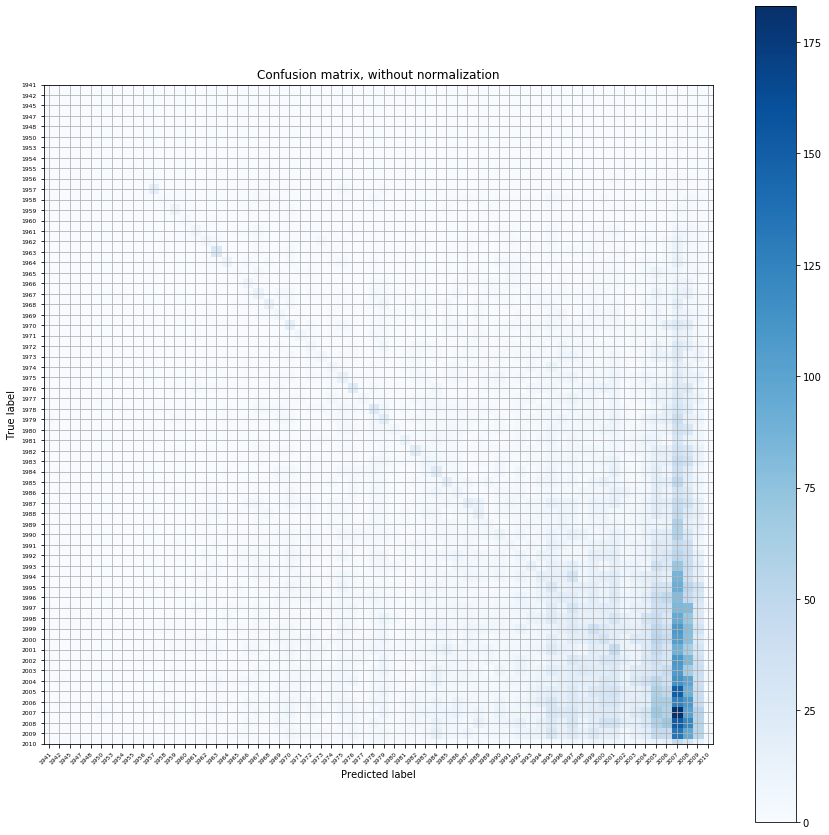

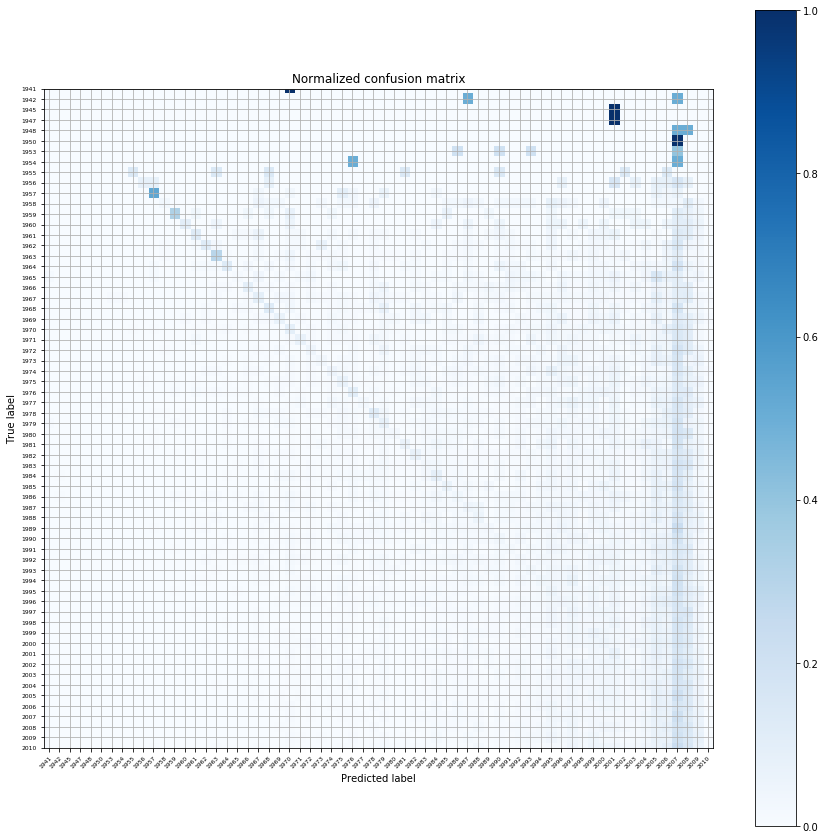

In [245]:
plot_confusion_matrix(labels_1hot, predicted, classes=year_filtered,
                      title='Confusion matrix, without normalization', show_labels=True)
plot_confusion_matrix(labels_1hot, predicted, classes=year_filtered, normalize=True,
                      title='Normalized confusion matrix', show_labels=True)